In [2]:
import wave as wave
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt


def calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N, c):
    # ysinΘ + xcosΘ
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    rc = 0.0365
    mic_angle = np.array(
        [
            0,
            np.pi / 4,
            np.pi / 2,
            np.pi * 3 / 4,
            np.pi,
            np.pi * (-3 / 4),
            np.pi * (-1 / 2),
            np.pi * (-1 / 4),
        ]
    )
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs * k / N
            for m in range(n_mic):
                delay = -rc * np.cos(th - mic_angle[m]) / c
                a[i, m, 0, k] = np.exp(-1j * 2 * np.pi * fk * delay)
    return a


def display_normalized_spectrum(spec, min_thre):
    """
    spec: スペクトル、direction x time_frame
    min_thre: スペクトルの平均値がこの値以下の時、検出対象がいないものとして0埋めする
    """
    modified_spec = np.zeros_like(spec)

    for i in range(spec.shape[1]):
        mean = np.mean(spec[:, i])
        if mean < min_thre:
            modified_spec[:, i] = 0
        else:
            min_val = spec[:, i].min()
            max_val = spec[:, i].max()
            modified_spec[:, i] = (spec[:, i] - min_val) / (max_val - min_val)

    color_min = 0
    color_max = 1
    plt.figure()
    plt.imshow(
        modified_spec,
        interpolation="nearest",
        aspect="auto",
        extent=[0, modified_spec.shape[1], -90, 90],
        vmin=color_min,
        vmax=color_max,
    )
    plt.colorbar()
    plt.ylabel("Direction of Arrival")
    plt.xlabel("Time[frame]")


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    print("sample width:", wav.getsampwidth())
    print("channel num:", wav.getnchannels())
    print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data

sample width: 2
channel num: 8
frames: 480192
multi_data.shape: (8, 480192)
X.shape:  (8, 257, 1877)


/tmp/ipykernel_5965/3470581202.py:68: ComplexWarning: Casting complex values to real discards the imaginary part
  P_DS[set_num - 1][i] = np.mean(aHRa / aHa)


P_DS.shape:  (181, 37)
P_DS.shape[0] 181


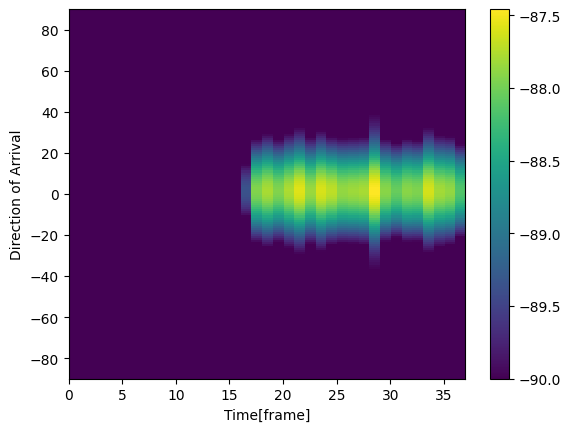

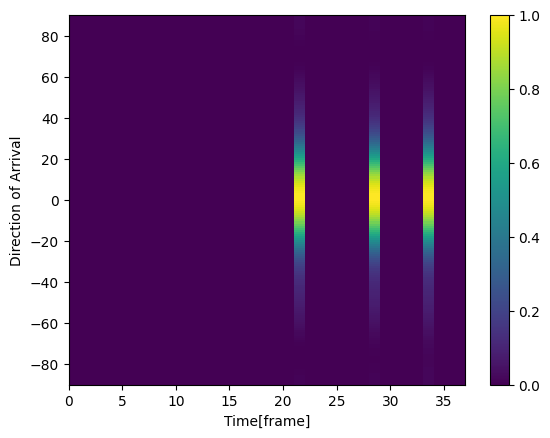

In [4]:
png_name = "DSBF.png"
n_mic = 8
n_src = 1
N = 512
window = "hann"
d = 0.01
c = 340
freq_l = 800
freq_h = 3000

mic_alignments = np.array(
    [
        [0.0365, 0.0, 0.0],
        [0.0258, 0.0258, 0.0],
        [0.0, 0.0365, 0.0],
        [-0.02580, 0.0258, 0.0],
        [-0.0365, 0.0, 0.0],
        [-0.0258, -0.0258, 0.0],
        [0.0, -0.0365, 0.0],
        [0.0258, -0.0258, 0.0],
    ]
)

# mic_alignments = np.array(
#     [
#         [0.0, 0.0365, 0.0],
#         [0.0258, 0.0258, 0.0],
#         [0.0365, 0.0, 0.0],
#         [0.0258, -0.02580, 0.0],
#         [0.0, -0.0365, 0.0],
#         [-0.0258, -0.0258, 0.0],
#         [-0.0365, 0.0, 0.0],
#         [-0.0258, 0.0258, 0.0],
#     ]
# )

fs = 16000

k_l = int(freq_l / (fs / N))
k_h = int(freq_h / (fs / N))

file_name = "whitenoise_-60.wav"
audio = load_onefile(file_name=file_name)

f, t, X = sp.stft(audio, fs, window=window, nperseg=N)
n_bin = X.shape[1]
print("X.shape: ", X.shape)

frame_set = 50
set_num = 1

theta = np.linspace(-90.0, 90.0, 181)
P_DS = np.zeros((X.shape[2] // 50, theta.shape[0]))
a = calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N, c)

while set_num * frame_set < X.shape[2]:
    X_trimed = X[:, :, (set_num - 1) * frame_set : set_num * frame_set]
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHR = np.einsum("mik,mek->ek", aH, R)
        aHRa = np.einsum("ek,eik->k", aHR, a[i])
        aHa = np.einsum("mik,mik->k", aH, a[i])
        aHa = abs(aHa) * abs(aHa)
        P_DS[set_num - 1][i] = np.mean(aHRa / aHa)

    set_num = set_num + 1

# 方向数 x 周波数インデックス数 x 時間軸　の3次元

P_DS = 10 * np.log10(P_DS)
P_DS = P_DS.transpose()
print("P_DS.shape: ", P_DS.shape)
print("P_DS.shape[0]", P_DS.shape[0])
color_min = -90
color_max = np.max(P_DS)
plt.figure()
plt.imshow(
    P_DS,
    interpolation="nearest",
    aspect="auto",
    extent=[0, P_DS.shape[1], -90, 90],
    vmin=color_min,
    vmax=color_max,
)
plt.colorbar()
plt.ylabel("Direction of Arrival")
plt.xlabel("Time[frame]")

display_normalized_spectrum(P_DS, min_thre=-90)